In [1]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()

llm = ChatOpenAI(model='gpt-4o')

small_llm = ChatOpenAI(model='gpt-4o-mini')

In [ ]:
from typing_extensions import TypedDict

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

router_system_prompt = """
    You are an expert at routing a user`s quetion to 'income_tax', 'llm', or 'real_estate_tax',
    'income_tax' contains information about income tax up to December 2025.
    'real_estate_tax' contains information about real estate tax up to December 2025
    if you think the question is not related to either 'income_tax' or 'real_estate_tax', you can route it to 'llm'
"""

router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system_prompt),
    ('user', '{query}')
])


class Route(BaseModel): 
    target: Literal['income_tax', 'llm', 'real_estate_tax'] = Field(
        description="The target for the query to answer"
    )

structured_router_llm = small_llm.with_structured_output(Route) 


def router(state: AgentState):
    query = state['query']
    router_chain = router_prompt | structured_router_llm 
    route = router_chain.invoke({'query': query})
    
    print(f'route == {route}')
    print(f'route.target == {route.target}')
    
    return route.target


In [29]:
from langchain_core.output_parsers import StrOutputParser

def call_llm(state: AgentState):
    query = state['query']
    llm_chain = small_llm | StrOutputParser()
    llm_answer = llm_chain.invoke(query)
    return {'answer': llm_answer}

In [31]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

In [32]:
from income_tax_graph import graph as income_tax_agent
from real_estate_tax_graph import graph as real_estate_tax_agent

graph_builder.add_node('income_tax', income_tax_agent)
graph_builder.add_node('real_estate_tax', real_estate_tax_agent)
graph_builder.add_node('llm', call_llm)

In [33]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        'income_tax': 'income_tax', 
        'real_estate_tax': 'real_estate_tax',
        'llm': 'llm', 
    }
)

graph_builder.add_edge('income_tax', END)
graph_builder.add_edge('real_estate_tax', END)
graph_builder.add_edge('llm', END)

In [34]:
graph = graph_builder.compile()

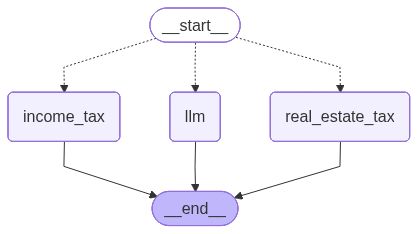

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
initial_state = {'query': '소득세란 무엇인가요?'}
graph.invoke(initial_state)

router route == target='income_tax'
route.target == income_tax
query: 소득세란 무엇인가요?
response doc relevance: {'Score': 1, 'Explanation': "To determine if the provided FACTS are relevant to the QUESTION, we need to assess whether the content contains any keywords or semantic meaning related to '소득세', which translates to 'income tax' in English.\n\n1. The FACTS provided are excerpts from a document related to income tax, as indicated by the repeated mention of '소득세법', which means 'Income Tax Law'.\n2. The excerpts include discussions on taxable and non-taxable income, categorization of income types (such as 종합소득 - comprehensive income, 퇴직소득 - retirement income, 양도소득 - transfer income), and specific provisions under the income tax law. These are directly related to understanding what income tax is, as they provide context on what types of income are subject to taxation and how they are classified and treated under the law.\n3. The FACTS discuss specific articles and amendments in the income 

{'query': '소득세란 무엇인가요?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content="제2장 거주자의 종합소득 및 퇴직소득에 대한 납세의무 <개정 2009. 12. 31.>\n제3절 비과세\n  [제3절 비과세 2009. 12. 31.]\n제12조(비과세소득) 다음 각 호의 소득에 대해서는 소득세를 과세하지 아니한다. <개정 2010. 12. 27. 2011. 7. 25., 2011. 9. 15, 2012. 1. 1, 2013. 1. 1, 2013. 2. 2, 2014. 1. 1, 2014. 3. 18, 2014. 12. 15, 2016. 12. 20., 2018. 3. 20, 2018. 12. 31, 2019. 12. 10., 2019. 12. 31, 2020. 12. 29, 2022. 8. 12, 2022. 12. 31, 2023. 8. 8, 2023. 12. 31.>\n1. ‘공익신탁법’에 따른 공익재단의 이익\n  가. 농. 임. 반을 작업 생산에 이용하여 물로서 발생하는 소득\n  나. 1개 국의 주택임대소득자 주택임대소득(제99조의 규정에 따른 기준시가가 12억원을 초과하는 주택 및 국외에 소재하는 주택의 임대소득을 제외한다) 또는 해상 주택세기금의 정하는 충분금액의 합계금이 2천 만원 이하인 자의 주택임대소득의 산정 또는 해당 과세기간까지 발생하는 소득으로 한정한다.\n  다. 대변동형으로 정하는 통의가 발행하는 소득\n  라. 대변동형으로 정하는 전종주제 제도를 통해 발생하는 소득\n  마. 조정기간이 1년 이상인 임차(賃) 노임(賃) 발생 또는 양도소득으로 연 600만원 이하 금액, 이 경우 조정기간 및 세액의 필요사항은 대변동형으로 정한다.\n  바. 대변동형으로 정하는 작목재배업에 발생하는 소득\n  사. 대변동형으로 정하는 사업이 아닌 소득이 발생하는 소득\n  가. 근로소득 퇴직소득 즉 다음 각 목의 이산에 해당하는 소득\n

In [15]:
initial_state = {'query': '15억원 짜리 집을 소유하고 있다면, 세금을 얼마나 내야하나요?'}
graph.invoke(initial_state)

router route == target='real_estate_tax'
route.target == real_estate_tax
context: [{'url': 'https://www.law.go.kr/LSW/lumLsLinkPop.do?lspttninfSeq=120262', 'content': '1. 지방세법 시행령  \n[시행 2025. 11. 25.] [대통령령 제35858호, 2025. 11. 25., 타법개정]\n\n 제109조 공정시장가액비율\n\n## 지방세법 시행령\n\n[시행 2025. 11. 25.] [대통령령 제35858호, 2025. 11. 25., 타법개정]\n\n  \n\n① 법 제110조제1항 각 호 외의 부분에서 “대통령령으로 정하는 공정시장가액비율”이란 다음 각 호의 구분에 따른 비율을 말한다. <개정 2022. 6. 30., 2023. 3. 14., 2023. 6. 30., 2024. 5. 28., 2025. 5. 27.>\n\n1. 토지 및 건축물: 시가표준액의 100분의 70\n\n2. 주택: 시가표준액의 100분의 60. 다만, 2025년도에 납세의무가 성립하는 재산세의 과세표준을 산정하는 경우 제110조의2에 따라 1세대 1주택으로 인정되는 주택(시가표준액이 9억원을 초과하는 주택을 포함한다)에 대해서는 다음 각 목의 구분에 따른다. [...] 가. 시가표준액이 3억원 이하인 주택: 시가표준액의 100분의 43\n\n나. 시가표준액이 3억원을 초과하고 6억원 이하인 주택: 시가표준액의 100분의 44\n\n다. 시가표준액이 6억원을 초과하는 주택: 시가표준액의 100분의 45\n\n② 행정안전부장관은 제1항에 따른 공정시장가액비율의 점검ㆍ평가를 위하여 필요한 경우 관계 전문기관에 조사ㆍ연구를 의뢰할 수 있다. <신설 2023. 3. 14.>\n\n 파일형식\n\n## 지방세법 시행령\n\n[시행 2025. 11. 25.] [대통령령 제35858호, 2025. 11. 25., 타법개정]\n\n  \n\n① 법 제110조제

{'query': '15억원 짜리 집을 소유하고 있다면, 세금을 얼마나 내야하나요?',
 'answer': '주어진 정보에 따르면, 1세대 1주택자로서 과세표준이 1억 3,500만 원입니다. 아래 표를 참고하여 주택 수가 1채인 경우의 종합부동산세를 계산해 보겠습니다.\n\n1. 과세표준이 1억 3,500만 원인 경우:\n   - 해당 과세표준은 "3억 원 이하" 구간에 해당합니다.\n\n2. 2주택 이하 소유자에 대한 세율표:\n   - 과세표준 3억 원 이하: 세율은 1천분의 5입니다.\n\n3. 따라서, 종합부동산세는 다음과 같이 계산됩니다:\n   - 종합부동산세 = 과세표준 × 세율\n   - 종합부동산세 = 1억 3,500만 원 × (5/1000)\n   - 종합부동산세 = 67만 5,000원\n\n따라서, 주택 공시가격이 15억 원이고 1세대 1주택자로서 과세표준이 1억 3,500만 원일 경우, 종합부동산세는 67만 5,000원이 됩니다.'}

In [37]:
initial_state = {'query': '스타벅스의 창업자는 누구인가요?'}
graph.invoke(initial_state)

router route == target='llm'
route.target == llm


{'query': '스타벅스의 창업자는 누구인가요?',
 'answer': '스타벅스의 창업자는 제리 볼드윈, 제프리 영, 그리고 고든 보커입니다. 이들은 1971년 미국 시애틀에서 스타벅스를 처음 설립하였습니다. 처음에는 커피를 판매하는 가게가 아닌, 커피 원두와 관련된 제품을 판매하는 상점이었습니다. 이후 하워드 슐츠가 1982년에 합류하면서 스타벅스의 현재와 같은 커피 전문점으로 발전하게 됩니다. 하워드 슐츠는 스타벅스의 성장과 글로벌 확장을 이끌며 회사의 대표적인 얼굴이 되었습니다.'}